# PCA Evaluation

___
This notebook is focused on the evaluation of principal component analysis (PCA).

PCA was used as a tool to study data projections that preserved most of the original data variance, evaluating the features that would have the largest weights, identifying them as the ones most important for such projections.

___

In [1]:
import pandas as pd
import numpy as np
import joblib
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from external_data_loading import get_siope_data 
from preprocess import correct_siope_indicators_by_inflation, load_and_process_data_for_analysis, get_dummies_for_categorical_variables, select_features_through_pca
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS

c:\Users\cstefano\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\cstefano\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## 1. Data 

For each given year, besides ENEM data for that year, we would also like to have the average external educational budget indicators (EBIs) over the last 'T' years. In other words, for any given year of our analysis, we will also calculate a set of features by average the corresponding EBI over the last 'T' years, with T ranging from [0,15].

In [2]:
# Definition of analysis focus
years_to_analyze = np.arange(2015, 2023)
time_windows = np.arange(0,16)

In [3]:
# Loading SIOPE data, and correcting for inflation
siope_df = get_siope_data("../Datasets/external-data/siope-data")
siope_df = correct_siope_indicators_by_inflation(siope_df)

## 2. Running analysis

In [4]:
def load_and_process_data_for_analysis_stepwise(year, siope_df):
    print(f"Loading data for ENEM {year}")
    enem_df = joblib.load(f"ENEM_preprocessed_{year}_based_on_SG_UF_PROVA.pkl")
    enem_df.drop(columns = ["UF", "Natural Sciences score", "Humanities score", "Languages score", "Math score"], inplace = True)
    enem_df.rename(columns = {"SG_UF_PROVA": "UF"}, inplace = True)

    # get metrics average values over last 'window' years
    print(f"Processing SIOPE data")
    siope_df2 = siope_df[(siope_df["year"] <= year)][["UF", "metric_description", "metric_value", "year"]]

    # Let us mark each feature with the corresponding year
    siope_df2['siope_features'] = siope_df2.apply(lambda x: x["metric_description"] + f'_{year - x["year"]}y', axis = 1)
    siope_df2 = siope_df2[["UF", "siope_features", "metric_value"]]
    
    # Normalization
    siope_df2 = ((siope_df2.pivot(index = "UF", columns = "siope_features", values = 'metric_value') - siope_df2.pivot(index = "UF", columns = "siope_features", values = 'metric_value').mean())/siope_df2.pivot(index = "UF", columns = "siope_features", values = 'metric_value').std())\
        .melt(ignore_index = False).reset_index()

    # Discard metrics to which there are null values (generally, UF's that are not in SIOPE's database for these years)
    siope_metrics_to_discard = (siope_df2.isna().sum() > 0).where(lambda x: x == True).dropna().index
    siope_df2.drop(columns = siope_metrics_to_discard, inplace = True)

    print(f"Merging ENEM and SIOPE data")
    enem_df = enem_df.merge(siope_df2, on = "UF", how = "inner")

    print("Ready to start analysis!")
    return enem_df

In [5]:
for year in [2022]:
    year_results = {} # to store results for that year
    
    # Merge ENEM and SIOPE data and get dataframe ready for PCA analysis, for a given ENEM year
    #df = load_and_process_data_for_analysis(year, time_windows, siope_df)
    df = load_and_process_data_for_analysis_stepwise(year, siope_df)
    df = get_dummies_for_categorical_variables(df)

    X = df.dropna().drop(columns = ["Average score", "UF"])
    y = df.dropna()["Average score"]

    # Running PCA
    features, variance, components_df, pca = select_features_through_pca(X, n_components = 5, top_features = 20)
    print(f"Selected {len(features)} features!")

    # Training OLS model
    print("Training linear regressor...")
    linear_regressor = OLS(y, exog = X[features], hasconst = False).fit()   
    
    # Training LMM
    print("Training linear mixed model...")
    try:
        LMM = sm.MixedLM(y, exog = X[features], groups = df.loc[X.index, :]["UF"]).fit()
        year_results["LMM"] = LMM
        del LMM
    except:
        print("Convergence problems!!")
    
    # Saving results
    print("Storing results...")
    year_results["features"] = features
    year_results["pca_variances"] = variance
    year_results["pca_weights"] = components_df
    year_results["pca"] = pca
    year_results["LR"] = linear_regressor
    year_results["y_train"] = y
    #year_results["y_test"] = y_test
    year_results["X_train"] = X
    #year_results["X_test"] = X_test
    joblib.dump(year_results, f"./variables_results/modelling_analysis_siope_{year}_ipca_corrected_stepwise_5PC.pkl")

    print("Results saved!")
    print("-"*30)
    print("\n")

    del linear_regressor, features, variance, components_df, df, X, y

Loading data for ENEM 2022
Processing SIOPE data
Merging ENEM and SIOPE data


In [47]:
# Variance caught by PCA for each year
variances = {'year': [], 'Componente principal': [], 'Fração da variância': []}
componentes = ["Primeira", "Segunda", "Terceira", "Quarta", "Quinta"]

for year in years_to_analyze:
    year_results = joblib.load(f"./variables_results/modelling_analysis_siope_{year}_ipca_corrected_stepwise_5PC.pkl")
    i = 0
    for value in year_results["pca_variances"]:
        variances["year"].append(year)
        variances["Componente principal"].append(componentes[i])
        variances["Fração da variância"].append(value)
        i += 1

del year_results

In [402]:
siope_df2 = siope_df[(siope_df["year"] <= year)][["UF", "metric_description", "metric_value", "year"]]

# Let us mark each feature with the corresponding year
siope_df2['siope_features'] = siope_df2.apply(lambda x: x["metric_description"] + f'_{year - x["year"]}y', axis = 1)
siope_df2 = siope_df2[["UF", "siope_features", "metric_value"]]
siope_df2["metric_value"] = (siope_df2["metric_value"] - siope_df2["metric_value"].mean())/siope_df2["metric_value"].std()

In [415]:
siope_df2 = siope_df[(siope_df["year"] <= year)][["UF", "metric_description", "metric_value", "year"]]

# Let us mark each feature with the corresponding year
siope_df2['siope_features'] = siope_df2.apply(lambda x: x["metric_description"] + f'_{year - x["year"]}y', axis = 1)
siope_df2 = siope_df2[["UF", "siope_features", "metric_value"]]
siope_df2.head()

,UF,siope_features,metric_value
0,RO,EI_FUNDEB_ratio_14y,0.00000
1,RO,EB_non_teaching_staff_per_student_expanses_14y,62.16433
2,RO,EM_FUNDEB_ratio_14y,0.00000
3,RO,EI_to_total_education_expanses_14y,0.00000
4,RO,EF_to_total_education_expanses_14y,78.36000


In [441]:
((siope_df2.pivot(index = "UF", columns = "siope_features", values = 'metric_value') - siope_df2.pivot(index = "UF", columns = "siope_features", values = 'metric_value').mean())/siope_df2.pivot(index = "UF", columns = "siope_features", values = 'metric_value').std())\
.melt(ignore_index = False).reset_index()

,UF,siope_features,value
0,AC,EB_expanses_teacher_per_student_0y,-0.261119
1,AL,EB_expanses_teacher_per_student_0y,NaN
2,AM,EB_expanses_teacher_per_student_0y,-1.812678
3,AP,EB_expanses_teacher_per_student_0y,1.682280
4,BA,EB_expanses_teacher_per_student_0y,-0.784219
...,...,...,...
8284,RS,superavit_or_deficit_9y,NaN
8285,SC,superavit_or_deficit_9y,0.473102
8286,SE,superavit_or_deficit_9y,0.270241
8287,SP,superavit_or_deficit_9y,-1.127505


In [406]:
siope_df.head()

,year,metric_code,metric_value,UF,metric_description
0,2008,2.1,0.00000,RO,EI_FUNDEB_ratio
1,2008,4.11,62.16433,RO,EB_non_teaching_staff_per_student_expanses
2,2008,2.3,0.00000,RO,EM_FUNDEB_ratio
3,2008,2.4,0.00000,RO,EI_to_total_education_expanses
4,2008,2.5,78.36000,RO,EF_to_total_education_expanses


In [412]:
siope_df2.groupby("siope_features")["metric_value"].mean()

siope_features
EB_expanses_teacher_per_student_0y    -0.053410
EB_expanses_teacher_per_student_10y   -0.053412
EB_expanses_teacher_per_student_11y   -0.053412
EB_expanses_teacher_per_student_12y   -0.053413
EB_expanses_teacher_per_student_13y   -0.053413
                                         ...   
superavit_or_deficit_5y                0.066637
superavit_or_deficit_6y               -0.032777
superavit_or_deficit_7y               -0.815280
superavit_or_deficit_8y                0.065458
superavit_or_deficit_9y               -0.080408
Name: metric_value, Length: 307, dtype: float64

In [405]:
siope_df2[siope_df2["siope_features"] == "superavit_or_deficit_4y"]

,UF,siope_features,metric_value
183,RO,superavit_or_deficit_4y,3.500306
504,AC,superavit_or_deficit_4y,-0.118252
810,AM,superavit_or_deficit_4y,0.455566
1117,RR,superavit_or_deficit_4y,0.330757
1413,PA,superavit_or_deficit_4y,-0.824675
1699,AP,superavit_or_deficit_4y,1.606166
2015,TO,superavit_or_deficit_4y,-0.661196
2312,MA,superavit_or_deficit_4y,-2.618261
2625,PI,superavit_or_deficit_4y,-0.197250
2931,CE,superavit_or_deficit_4y,-1.035234


In [78]:
var_df = pd.DataFrame(variances)

var_df["cumsum"] = var_df.groupby("year")["Fração da variância"].cumsum()
var_df.head()

,year,Componente principal,Fração da variância,cumsum
0,2015,Primeira,0.537180,0.537180
1,2015,Segunda,0.250270,0.787450
2,2015,Terceira,0.073998,0.861449
3,2015,Quarta,0.036340,0.897788
4,2015,Quinta,0.024322,0.922111


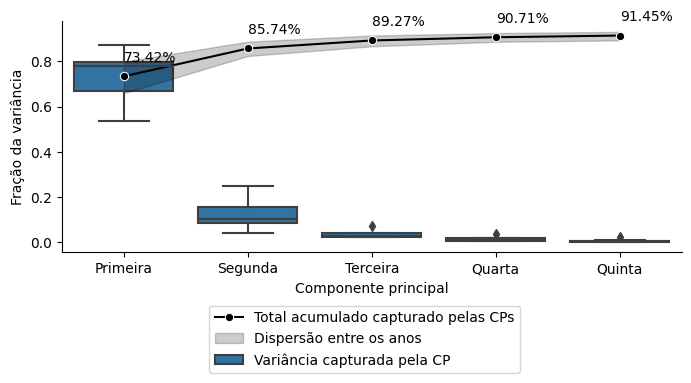

In [145]:
var_df = pd.DataFrame(variances)
var_df["Total acumulado"] = var_df.groupby("year")["Fração da variância"].cumsum()

_, ax = plt.subplots(1,1, figsize = (8,3))

sns.lineplot(data = var_df,
             x = "Componente principal",
             y = "Total acumulado",
             marker = 'o',
             color = 'k',
             ax = ax,
             legend = True)


sns.boxplot(data = var_df,
            x = "Componente principal",
            y = "Fração da variância",
            color = "#1f77b4",
            ax = ax)


for x, y in zip(var_df["Componente principal"], np.sort(var_df.groupby(["Componente principal"])["Total acumulado"].mean().values)):
    plt.text(x = x, y = y + 0.065, s = '{:.2f}%'.format(100*y), color = 'black')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.legend(["Total acumulado capturado pelas CPs",
            "Dispersão entre os anos",
            "Variância capturada pela CP"], bbox_to_anchor = (0.75, -0.2))

In [146]:
year_results = joblib.load("./variables_results/modelling_analysis_siope_2022_ipca_corrected_stepwise_5PC.pkl")

In [173]:
df = pd.DataFrame(year_results["pca"].transform(year_results["X_train"]), columns = ["PC" + f"{i}" for i in np.arange(1,6)])
y = year_results["y_train"]
df["y"] = y.values

In [174]:
q1 = np.quantile(df["y"], 0.25)
q2 = np.quantile(df["y"], 0.50)
q3 = np.quantile(df["y"], 0.75)

df["Categoria"] = df["y"].apply(lambda x: "Q3+" if x > q3
                                else "Q1 - Q2" if x > q2
                                else "Q1-")

del y

<AxesSubplot: xlabel='PC4', ylabel='PC1'>

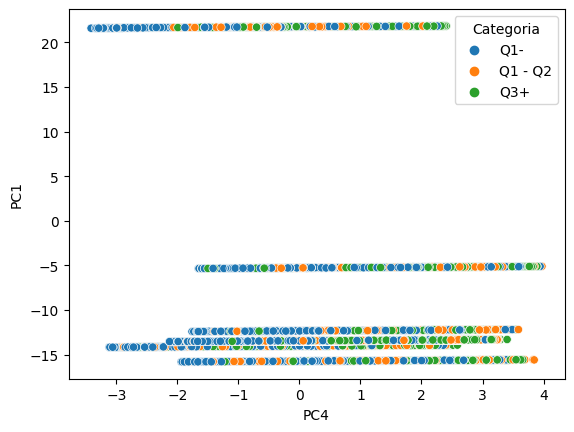

In [179]:
sns.scatterplot(data = df,
                x = "PC4",
                y = "PC1",
                hue = "Categoria")

### Features selected per year

In [183]:
d = {'a': [1], 'b': [1,2]}
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))

,a,b
0,1.0,1
1,NaN,2


In [199]:
features_dict = {"year": [], "feature": []}
weights_df = pd.DataFrame()

for year in years_to_analyze:
    year_results = joblib.load(f"./variables_results/modelling_analysis_siope_{year}_ipca_corrected_stepwise_5PC.pkl")

    for feature in year_results["features"]:
        features_dict["year"].append(year)
        features_dict["feature"].append(feature)
    
    aux_df = year_results["pca_weights"].reset_index()
    aux_df["year"] = year
    weights_df = pd.concat([weights_df, aux_df], axis = 0)

features_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in features_dict.items() ]))
del year_results, features_dict


In [277]:
weights_df[weights_df["index"] == "PC1"]

,index,EB_expanses_teacher_per_student_0y,EB_expanses_teacher_per_student_1y,EB_expanses_teacher_per_student_2y,EB_expanses_teacher_per_student_3y,EB_expanses_teacher_per_student_4y,EB_expanses_teacher_per_student_5y,EB_expanses_teacher_per_student_6y,EB_expanses_teacher_per_student_7y,EB_investment_per_student_0y,...,FUNDEB_teacher_to_total_MDE_14y,average_teacher_expanses_EB_6y,courseware_investment_14y,education_to_overall_expanses_14y,education_to_total_MDE_investments_14y,investment_per_student_14y,investment_per_student_to_PIB_per_capita_5y,scholar_nutrition_to_total_education_expanses_14y,superavit_or_deficit_13y,High school conclusion year_16
0,PC1,-5.962905e-09,7.499761e-08,7.108463e-09,1.237525e-08,-3.037077e-08,-2.421687e-08,-3.075168e-08,-4.820485e-08,-9.481375e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,PC1,1.015294e-07,7.056356e-08,6.144404e-08,8.569382e-08,9.744034e-08,3.928930e-08,3.856824e-08,2.276298e-08,-2.618324e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,PC1,-2.069302e-07,-2.163572e-07,-2.652721e-07,-9.510984e-08,-1.798987e-07,-6.861104e-08,-3.805796e-08,-4.981029e-08,-2.547259e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,PC1,5.460936e-08,1.075651e-07,1.150179e-07,1.502638e-07,5.261032e-08,9.978966e-08,3.136959e-08,1.773933e-08,1.617531e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,PC1,7.272199e-08,5.358472e-08,1.056369e-07,1.128726e-07,1.472821e-07,5.138164e-08,9.747547e-08,3.058585e-08,1.285924e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,PC1,8.527763e-08,6.242067e-08,4.343624e-08,9.275668e-08,9.931841e-08,1.306447e-07,4.592227e-08,8.512622e-08,1.286253e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,PC1,-1.295790e-08,8.469571e-08,6.251305e-08,4.504817e-08,9.451356e-08,1.006922e-07,1.310082e-07,4.624129e-08,1.050248e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,PC1,3.583322e-08,-1.017567e-08,3.721746e-08,2.740556e-08,1.867319e-08,5.081010e-08,5.267134e-08,6.705435e-08,8.029522e-08,...,-1.860793e-11,-2.739823e-11,-2.970668e-35,9.700733e-10,-2.938527e-11,1.131599e-08,-2.970668e-35,-1.414900e-11,0.021347,-0.000538


In [388]:
        aux = weights_df[(weights_df["year"] == 2022) & (weights_df["index"] == "PC1")].drop(columns = ["index", "year"])
        aux =(100*abs(aux)/abs(aux).sum().sum()).transpose().sort_values(by = 0, ascending = False)[0:30].reset_index(names = "feature").rename(columns = {0: "rel_weight"})

In [389]:
aux.shape

(30, 2)

In [379]:
def get_top_features_df(weights_df, years_to_analyze, pc, n_features):
    top_features_weights = pd.DataFrame()
    for year in years_to_analyze:
        aux = weights_df[(weights_df["year"] == year) & (weights_df["index"] == pc)].drop(columns = ["index", "year"])
        aux =(100*abs(aux)/abs(aux).sum().sum()).transpose().sort_values(by = int(pc[-1])-1, ascending = False)[0:n_features].reset_index(names = "feature").rename(columns = {int(pc[-1])-1: "rel_weight"})
        aux["year"] = year
    
        top_features_weights = pd.concat([top_features_weights, aux], axis = 0)
        
    return top_features_weights

In [401]:
siope_df

,year,metric_code,metric_value,UF,metric_description
0,2008,2.1,0.000000,RO,EI_FUNDEB_ratio
1,2008,4.11,62.164330,RO,EB_non_teaching_staff_per_student_expanses
2,2008,2.3,0.000000,RO,EM_FUNDEB_ratio
3,2008,2.4,0.000000,RO,EI_to_total_education_expanses
4,2008,2.5,78.360000,RO,EF_to_total_education_expanses
...,...,...,...,...,...
7393,2017,2.12,0.160000,DF,education_to_total_MDE_investments
7394,2017,3.5,73.010000,DF,FUNDEB_teacher_to_total_MDE
7395,2017,4.1,4253.602753,DF,EI_investment_per_student
7396,2017,4.2,5643.706925,DF,EF_investment_per_student


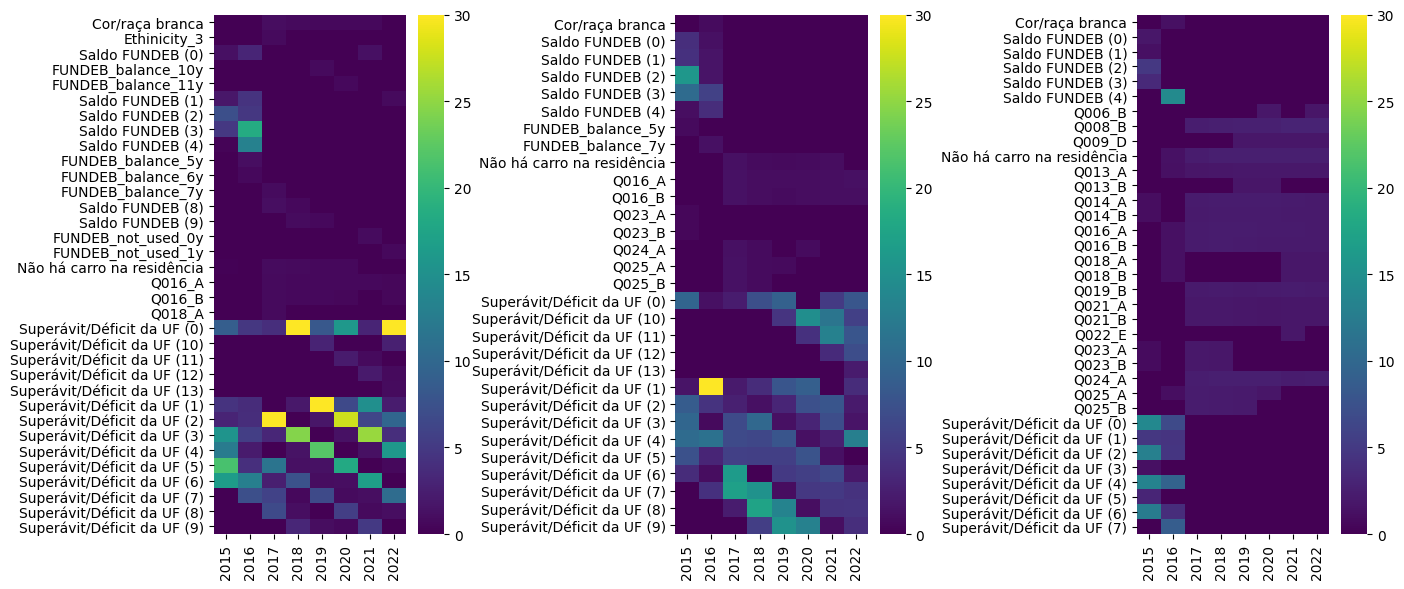

In [400]:
_, ax = plt.subplots(1,3, figsize = (14,6))
i = 0
for pc in ["PC1", "PC2", "PC4"]:
    top_features_weights = get_top_features_df(weights_df, years_to_analyze, pc, 15)
    sns.heatmap(top_features_weights.pivot(index = "feature", columns = "year", values = "rel_weight").fillna(-10).rename(index = renaming_dict),
            cmap = 'viridis', vmin = 0, vmax = 30, ax = ax[i], yticklabels = True)
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
    i += 1  
plt.tight_layout()
    

In [289]:
top_features_weights = pd.DataFrame()
for year in years_to_analyze:
    aux = weights_df[(weights_df["year"] == year) & (weights_df["index"] == "PC1")].drop(columns = ["index", "year"])
    aux =(100*abs(aux)/abs(aux).sum().sum()).transpose().sort_values(by = 0, ascending = False)[0:10].reset_index(names = "feature").rename(columns = {0: "rel_weight"})
    aux["year"] = year
    
    top_features_weights = pd.concat([top_features_weights, aux], axis = 0)
del aux

In [309]:
desired_features_order = ["Ethinicity_1", "Q010_A", "FUNDEB_balance_0y", "FUNDEB_balance_1y", "FUNDEB_balance_2y", "FUNDEB_balance_3y", "FUNDEB_balance_4y",
                          "FUNDEB_balance_8y", "FUNDEB_balance_9y", "superavit_or_deficit_0y", "superavit_or_deficit_1y", "superavit_or_deficit_2y", "superavit_or_deficit_3y",
                          "superavit_or_deficit_4y", "superavit_or_deficit_5y", "superavit_or_deficit_6y", "superavit_or_deficit_7y", "superavit_or_deficit_8y", "superavit_or_deficit_9y",
                          "superavit_or_deficit_10y", "superavit_or_deficit_11y", "superavit_or_deficit_12y", "superavit_or_deficit_13y"]

In [ ]:
top_features_weights.pivot(index = "feature", columns = "year", values = "rel_weight")

In [325]:
renaming_dict = {"Ethinicity_1": "Cor/raça branca",
                 "Q010_A": "Não há carro na residência",
                 "Q016_A": "Não há forno microondas na residência",
                 "FUNDEB_balance_0y": "Saldo FUNDEB (0)",
                 "FUNDEB_balance_1y": "Saldo FUNDEB (1)",
                 "FUNDEB_balance_2y": "Saldo FUNDEB (2)",
                 "FUNDEB_balance_3y": "Saldo FUNDEB (3)",
                 "FUNDEB_balance_4y": "Saldo FUNDEB (4)",
                 "FUNDEB_balance_8y": "Saldo FUNDEB (8)",
                 "FUNDEB_balance_9y": "Saldo FUNDEB (9)",
                 "superavit_or_deficit_0y": "Superávit/Déficit da UF (0)",
                 "superavit_or_deficit_1y": "Superávit/Déficit da UF (1)",
                 "superavit_or_deficit_2y": "Superávit/Déficit da UF (2)",
                 "superavit_or_deficit_3y": "Superávit/Déficit da UF (3)",
                 "superavit_or_deficit_4y": "Superávit/Déficit da UF (4)",
                 "superavit_or_deficit_5y": "Superávit/Déficit da UF (5)",
                 "superavit_or_deficit_6y": "Superávit/Déficit da UF (6)",
                 "superavit_or_deficit_7y": "Superávit/Déficit da UF (7)",
                 "superavit_or_deficit_8y": "Superávit/Déficit da UF (8)",
                 "superavit_or_deficit_9y": "Superávit/Déficit da UF (9)",
                 "superavit_or_deficit_10y": "Superávit/Déficit da UF (10)",
                 "superavit_or_deficit_11y": "Superávit/Déficit da UF (11)",
                 "superavit_or_deficit_12y": "Superávit/Déficit da UF (12)",
                 "superavit_or_deficit_13y": "Superávit/Déficit da UF (13)"}

<AxesSubplot: xlabel='year', ylabel='feature'>

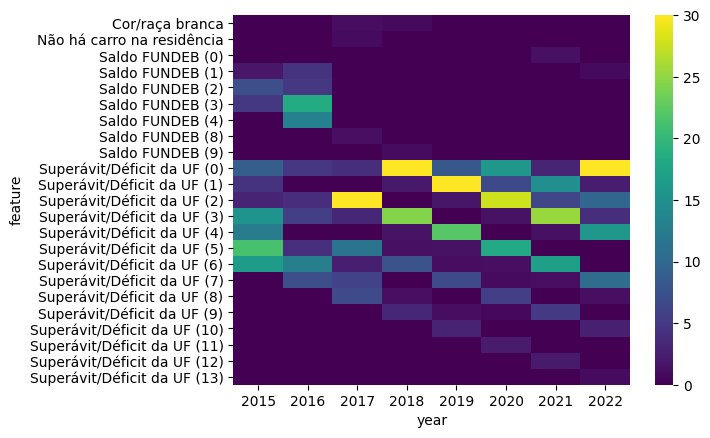

In [326]:
sns.heatmap(top_features_weights.pivot(index = "feature", columns = "year", values = "rel_weight").loc[desired_features_order, :].fillna(-10).rename(index = renaming_dict),
            cmap = 'viridis', vmin = 0, vmax = 30)

<AxesSubplot: xlabel='year', ylabel='feature'>

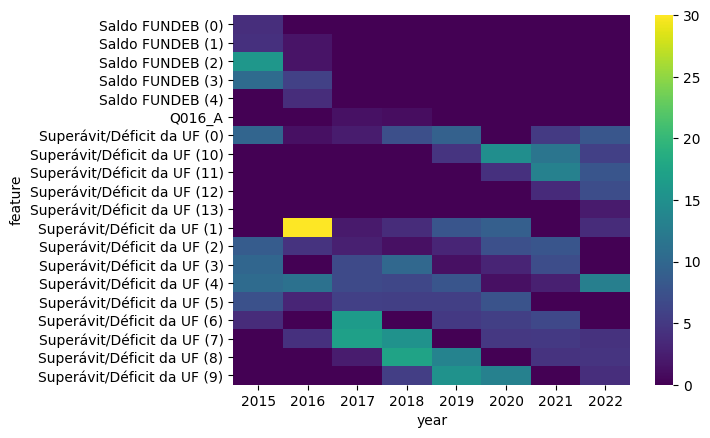

In [330]:
top_features_weights = pd.DataFrame()
for year in years_to_analyze:
    aux = weights_df[(weights_df["year"] == year) & (weights_df["index"] == "PC2")].drop(columns = ["index", "year"])
    aux =(100*abs(aux)/abs(aux).sum().sum()).transpose().sort_values(by = 1, ascending = False)[0:10].reset_index(names = "feature").rename(columns = {1: "rel_weight"})
    aux["year"] = year
    
    top_features_weights = pd.concat([top_features_weights, aux], axis = 0)
del aux

sns.heatmap(top_features_weights.pivot(index = "feature", columns = "year", values = "rel_weight").fillna(-10).rename(index = renaming_dict),
            cmap = 'viridis', vmin = 0, vmax = 30)

In [338]:
ax

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >], dtype=object)

In [342]:
top_features_weights.pivot(index = "feature", columns = "year", values = "rel_weight").fillna(-10).rename(index = renaming_dict)

year,2022
feature,
Saldo FUNDEB (1),0.767974
Superávit/Déficit da UF (0),33.637210
Superávit/Déficit da UF (10),2.674368
Superávit/Déficit da UF (13),0.861706
Superávit/Déficit da UF (1),2.274819
Superávit/Déficit da UF (2),9.843045
Superávit/Déficit da UF (3),3.969339
Superávit/Déficit da UF (4),16.009988
Superávit/Déficit da UF (7),10.433105


In [347]:
top_features_weights

,feature,rel_weight,year
0,superavit_or_deficit_0y,33.637210,2022
1,superavit_or_deficit_4y,16.009988,2022
2,superavit_or_deficit_7y,10.433105,2022
3,superavit_or_deficit_2y,9.843045,2022
4,superavit_or_deficit_3y,3.969339,2022
5,superavit_or_deficit_10y,2.674368,2022
6,superavit_or_deficit_1y,2.274819,2022
7,superavit_or_deficit_8y,1.093711,2022
8,superavit_or_deficit_13y,0.861706,2022
9,FUNDEB_balance_1y,0.767974,2022


2015
2016
2017
2018
2019
2020
2021
2022
2015


KeyError: 0

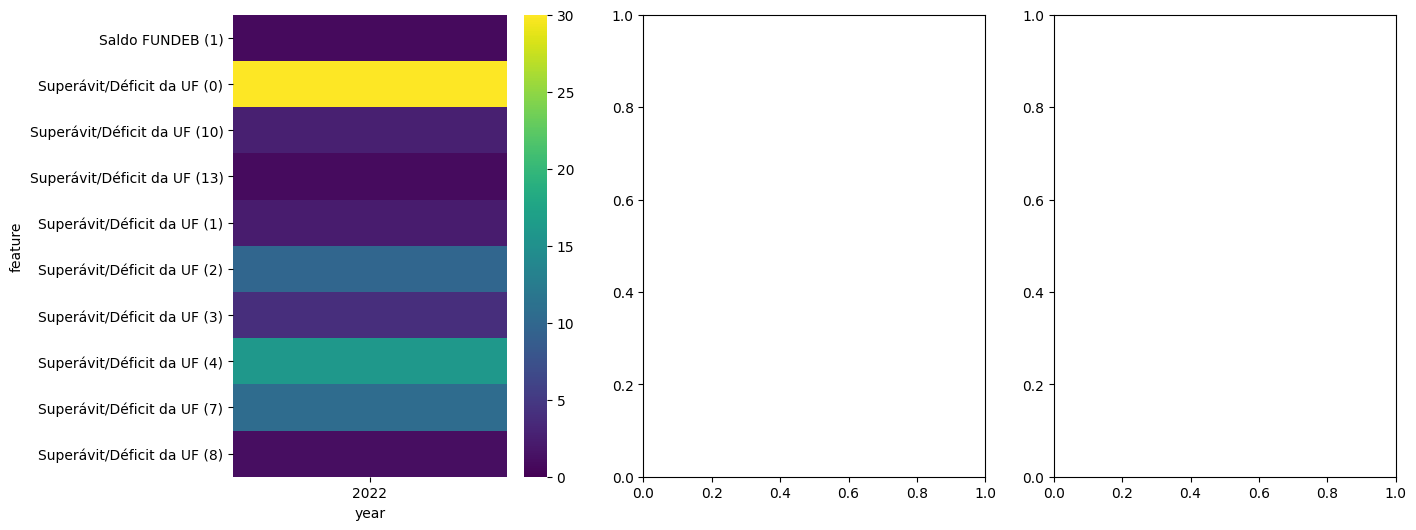

In [345]:
_, ax = plt.subplots(1,3, figsize = (15,6))
i = 0
for pc in ["PC1", "PC2", "PC3"]:
    top_features_weights = get_top_features_df(weights_df, years_to_analyze, pc)
    sns.heatmap(top_features_weights.pivot(index = "feature", columns = "year", values = "rel_weight").fillna(-10).rename(index = renaming_dict),
            cmap = 'viridis', vmin = 0, vmax = 30, ax = ax[i])
    i += 1
    


In [267]:
teste = weights_df[(weights_df["year"] == 2022) & (weights_df["index"] == "PC1")].drop(columns = ["index", "year"])
(100*abs(teste)/abs(teste).sum().sum()).transpose().sort_values(by = 0, ascending = False)[0:15]

,0
superavit_or_deficit_0y,33.637210
superavit_or_deficit_4y,16.009988
superavit_or_deficit_7y,10.433105
superavit_or_deficit_2y,9.843045
superavit_or_deficit_3y,3.969339
superavit_or_deficit_10y,2.674368
superavit_or_deficit_1y,2.274819
superavit_or_deficit_8y,1.093711
superavit_or_deficit_13y,0.861706
FUNDEB_balance_1y,0.767974


In [215]:
year_results = joblib.load(f"./variables_results/modelling_analysis_siope_2022_ipca_corrected_stepwise_5PC.pkl")

In [216]:
year_results["pca"].explained_variance_ratio_

array([0.8716834 , 0.04070113, 0.02513911, 0.00592354, 0.00258417])

In [213]:
weights_df[weights_df["year"] == 2022]

,index,EB_expanses_teacher_per_student_0y,EB_expanses_teacher_per_student_1y,EB_expanses_teacher_per_student_2y,EB_expanses_teacher_per_student_3y,EB_expanses_teacher_per_student_4y,EB_expanses_teacher_per_student_5y,EB_expanses_teacher_per_student_6y,EB_expanses_teacher_per_student_7y,EB_investment_per_student_0y,...,FUNDEB_teacher_to_total_MDE_14y,average_teacher_expanses_EB_6y,courseware_investment_14y,education_to_overall_expanses_14y,education_to_total_MDE_investments_14y,investment_per_student_14y,investment_per_student_to_PIB_per_capita_5y,scholar_nutrition_to_total_education_expanses_14y,superavit_or_deficit_13y,High school conclusion year_16
0,PC1,3.583322e-08,-1.017567e-08,3.721746e-08,2.740556e-08,1.867319e-08,5.081010e-08,5.267134e-08,6.705435e-08,8.029522e-08,...,-1.860793e-11,-2.739823e-11,-2.970668e-35,9.700733e-10,-2.938527e-11,1.131599e-08,-2.970668e-35,-1.414900e-11,0.021347,-0.000538
1,PC2,-3.563039e-08,3.138435e-08,1.396028e-07,9.975901e-08,2.197293e-08,-4.927195e-09,2.872125e-08,9.967976e-08,3.245408e-07,...,-5.716653e-09,-7.551997e-10,-5.938454e-33,1.623563e-09,-2.236464e-09,4.326087e-07,-5.938454e-33,6.859247e-11,0.098213,-0.002417
2,PC3,-3.591785e-07,-5.287025e-08,-2.587240e-07,-2.048032e-07,-2.815749e-07,-2.167931e-07,-2.225557e-07,-2.248553e-07,-4.883761e-07,...,-5.947294e-09,5.448573e-11,2.323971e-33,-1.600518e-09,6.399553e-10,9.147548e-08,2.323971e-33,-1.289849e-10,-0.352668,-0.000443
3,PC4,5.945409e-08,1.386656e-08,2.795791e-08,2.309209e-08,3.824778e-08,4.191601e-08,3.147338e-08,1.329190e-08,1.087573e-08,...,1.354440e-09,1.107204e-10,6.244363e-33,-2.463295e-11,2.638493e-10,-5.811591e-08,6.244363e-33,2.860426e-12,0.030264,-0.007128
4,PC5,1.971595e-08,5.684751e-09,2.025571e-08,7.664698e-09,1.078478e-08,6.764127e-09,4.004129e-09,2.084337e-09,-5.376375e-09,...,2.603153e-11,1.292083e-11,-1.118099e-32,-4.503373e-11,-1.034188e-10,-1.865156e-08,-1.118099e-32,9.630408e-12,0.002424,-0.042749


In [207]:
features_df.head(15)

,year,feature
0,2015,Q011_B
1,2015,superavit_or_deficit_6y
2,2015,Q014_A
3,2015,Q018_B
4,2015,Q006_B
5,2015,Q016_B
6,2015,Q003_A
7,2015,School type_Public
8,2015,superavit_or_deficit_0y
9,2015,Q018_A


In [197]:
year_results["pca_weights"].reset_index()

,index,EB_expanses_teacher_per_student_0y,EB_expanses_teacher_per_student_10y,EB_expanses_teacher_per_student_11y,EB_expanses_teacher_per_student_12y,EB_expanses_teacher_per_student_13y,EB_expanses_teacher_per_student_14y,EB_expanses_teacher_per_student_1y,EB_expanses_teacher_per_student_2y,EB_expanses_teacher_per_student_3y,...,High school conclusion year_7,High school conclusion year_8,High school conclusion year_9,High school conclusion year_10,High school conclusion year_11,High school conclusion year_12,High school conclusion year_13,High school conclusion year_14,High school conclusion year_15,High school conclusion year_16
0,PC1,3.583322e-08,7.352048e-09,-6.886801e-09,-1.360610e-09,1.405445e-08,1.430148e-08,-1.017567e-08,3.721746e-08,2.740556e-08,...,-0.000118,-0.000086,-0.000091,-0.000077,-0.000068,-0.000086,-0.000070,-0.000060,-0.000074,-0.000538
1,PC2,-3.563039e-08,7.610807e-08,1.826158e-07,2.308300e-07,1.160857e-07,1.311918e-07,3.138435e-08,1.396028e-07,9.975901e-08,...,-0.000671,-0.000703,-0.000538,-0.000597,-0.000465,-0.000440,-0.000456,-0.000378,-0.000389,-0.002417
2,PC3,-3.591785e-07,-1.635245e-07,-1.818966e-07,-1.493398e-07,-9.089097e-08,-1.247794e-07,-5.287025e-08,-2.587240e-07,-2.048032e-07,...,-0.000571,-0.000337,-0.000323,-0.000325,-0.000339,-0.000288,-0.000232,-0.000202,-0.000256,-0.000443
3,PC4,5.945409e-08,3.842274e-09,-1.148004e-08,-2.585797e-08,-7.603287e-09,-3.671897e-09,1.386656e-08,2.795791e-08,2.309209e-08,...,-0.004070,-0.003160,-0.003021,-0.002843,-0.002297,-0.002180,-0.001960,-0.001611,-0.001559,-0.007128
4,PC5,1.971595e-08,-1.314761e-09,1.220197e-09,-2.863490e-09,-9.877806e-09,-1.158770e-08,5.684751e-09,2.025571e-08,7.664698e-09,...,-0.015039,-0.012278,-0.010075,-0.009141,-0.007303,-0.006929,-0.006086,-0.005480,-0.005220,-0.042749


In [191]:
features_df[features_df["year"] == 201]

,year,feature
52,2016,High school conclusion year_11
53,2016,Q008_B
54,2016,FUNDEB_balance_7y
55,2016,superavit_or_deficit_6y
56,2016,Q014_A
57,2016,Q018_B
58,2016,Q025_A
59,2016,Q006_B
60,2016,Q024_B
61,2016,Q016_B


In [188]:
len(year_results["features"])

NameError: name 'year_results' is not defined

In [11]:
y_train = year_results["y_train"]
plt.scatter(y_train, year_results["LR"].predict(year_results["X_train"][year_results["features"]]))
xx = np.linspace(y_train.min(), y_train.max())
yy = xx
plt.plot(xx, yy, '-.r')

ValueError: shapes (323209,18) and (2,) not aligned: 18 (dim 1) != 2 (dim 0)

In [28]:
year_results["features"]

['Q016_B',
 'superavit_or_deficit_2014',
 'superavit_or_deficit_2009',
 'FUNDEB_not_used_2021',
 'superavit_or_deficit_2021',
 'Q016_A',
 'superavit_or_deficit_2013',
 'superavit_or_deficit_2012',
 'superavit_or_deficit_2018',
 'superavit_or_deficit_2010',
 'superavit_or_deficit_2019',
 'superavit_or_deficit_2011',
 'superavit_or_deficit_2017',
 'FUNDEB_balance_2021',
 'superavit_or_deficit_2016',
 'superavit_or_deficit_2015',
 'superavit_or_deficit_2020',
 'superavit_or_deficit_2022']

In [160]:
year_results["LR"].llf

-1983969.6006806486

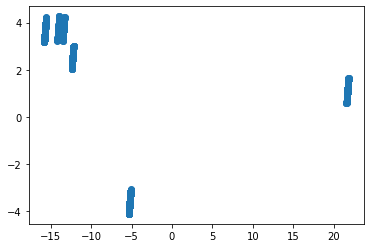

In [158]:
plt.scatter(year_results["pca"].transform(year_results["X_train"])[:,0], year_results["pca"].transform(year_results["X_train"])[:,1])

In [12]:
year_results["LR"].predict(year_results["pca"].transform(year_results["X_train"])).min()

-23.66890441096166

-1438055.5130847173

In [147]:
from sklearn.metrics import r2_score
r2_score(year_results["y_test"], year_results["LMM"].predict(year_results["pca"].transform(year_results["X_test"])))

-2299.3115909518374

In [25]:
year_results["LR"].llf

-1797483.8281056865

In [26]:
year_results["LMM"].llf

-1797290.854391674

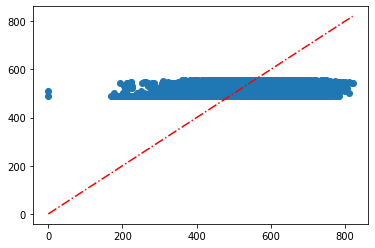

In [24]:
import matplotlib.pyplot as plt
y_train = year_results["y_train"]
plt.scatter(y_train, year_results["LR"].predict(year_results["X_train"][year_results["features"]]))
xx = np.linspace(y_train.min(), y_train.max())
yy = xx
plt.plot(xx, yy, '-.r')

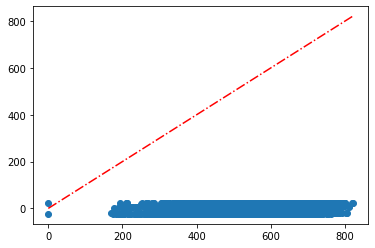

In [14]:
y_test = year_results["y_train"]
plt.scatter(y_test, year_results["LR"].predict(year_results["pca"].transform(year_results["X_train"])))
xx = np.linspace(y_test.min(), y_test.max())
yy = xx
plt.plot(xx, yy, '-.r')

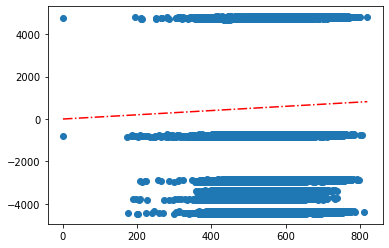

In [136]:
y_test = year_results["y_train"]
plt.scatter(y_test, year_results["LMM"].predict(year_results["pca"].transform(year_results["X_train"])))
xx = np.linspace(y_test.min(), y_test.max())
yy = xx
plt.plot(xx, yy, '-.r')

In [109]:
def select_features_through_pca(X_train, n_components, top_features):
    print(f"Fitting PCA to training data...")
    pca = PCA(n_components = n_components)
    pca.fit(X_train)
    features_to_use = []

    explained_variance = pca.explained_variance_ratio_

    components_to_features_df = pd.DataFrame(pca.components_,columns=X_train.columns, index = ["PC" + f"{i}" for i in range(1, n_components + 1)])

    print("Evaluating features...")
    for component in components_to_features_df.index:
    # for component in ["PC1"]:
        aux_list = abs(components_to_features_df.loc[component, :]).sort_values(ascending = False)[0:top_features].index.to_list()
        
        for feature in aux_list:
            features_to_use.append(feature)

    print("Found the set of features!")
    return list(set(features_to_use)), explained_variance, components_to_features_df, pca

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Average score   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          5.806e+05
Date:                Sat, 27 Jan 2024   Prob (F-statistic):                        0.00
Time:                        16:23:13   Log-Likelihood:                     -1.4258e+06
No. Observations:              258567   AIC:                                  2.852e+06
Df Residuals:                  258534   BIC:                                  2.852e+06
Df Model:                          33                                                  
Covariance Type:            nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Q013_A                          -12.5801      0.291    -43.212      0.000     -13.151     -12.010
Q019_B                           -5.7317      0.306    -18.744      0.000      -6.331      -5.132
Q009_D                           -0.9685      0.376     -2.578      0.010      -1.705      -0.232
Q001_E                            2.9124      0.271     10.759      0.000       2.382       3.443
School type_No answer           -27.8214      0.584    -47.637      0.000     -28.966     -26.677
Q018_A                         4.638e+10   1.01e+12      0.046      0.963   -1.93e+12    2.02e+12
Q002_E                            1.2227      0.256      4.773      0.000       0.721       1.725
FUNDEB_not_used_2021           2.083e+10   1.87e+10      1.117      0.264   -1.57e+10    5.74e+10
superavit_or_deficit_2015       1.74e+12   1.47e+12      1.187      0.235   -1.13e+12    4.61e+12
Age group_2                      11.1188      0.425     26.160      0.000      10.286      11.952
superavit_or_deficit_2014     -3.147e+11   2.83e+11     -1.110      0.267    -8.7e+11    2.41e+11
superavit_or_deficit_2018      7.395e+11   6.25e+11      1.183      0.237   -4.86e+11    1.96e+12
Q008_B                          -12.4850      0.313    -39.900      0.000     -13.098     -11.872
superavit_or_deficit_2020     -2.278e+11   2.32e+11     -0.984      0.325   -6.82e+11    2.26e+11
Q011_A                           16.0390      0.713     22.492      0.000      14.641      17.437
superavit_or_deficit_2022     -3.029e+10   5.82e+10     -0.521      0.602   -1.44e+11    8.37e+10
School type_Public              -33.1883      0.523    -63.480      0.000     -34.213     -32.164
Q009_C                            0.8457      0.337      2.506      0.012       0.184       1.507
Q014_A                           10.0676      1.012      9.952      0.000       8.085      12.050
superavit_or_deficit_2021      1.929e+11   1.88e+11      1.024      0.306   -1.76e+11    5.62e+11
High school conclusion year_0   -35.6835      0.390    -91.511      0.000     -36.448     -34.919
superavit_or_deficit_2010      2.032e+11   2.45e+11      0.828      0.408   -2.78e+11    6.84e+11
Age group_4                       5.3289      0.495     10.765      0.000       4.359       6.299
Q018_B                         4.638e+10   1.01e+12      0.046      0.963   -1.93e+12    2.02e+12
Q014_B                           11.2097      0.968     11.578      0.000       9.312      13.107
Age group_3                      11.2897      0.453     24.931      0.000      10.402      12.177
High school conclusion year_2    -9.0719      0.593    -15.300      0.000     -10.234      -7.910
FUNDEB_balance_2021            8.941e+10   1

In [112]:
year_results["pca_weights"]

,EB_expanses_teacher_per_student_2008,EB_expanses_teacher_per_student_2009,EB_expanses_teacher_per_student_2010,EB_expanses_teacher_per_student_2011,EB_expanses_teacher_per_student_2012,EB_expanses_teacher_per_student_2013,EB_expanses_teacher_per_student_2014,EB_expanses_teacher_per_student_2015,EB_expanses_teacher_per_student_2016,EB_expanses_teacher_per_student_2017,...,High school conclusion year_7,High school conclusion year_8,High school conclusion year_9,High school conclusion year_10,High school conclusion year_11,High school conclusion year_12,High school conclusion year_13,High school conclusion year_14,High school conclusion year_15,High school conclusion year_16
PC1,1.429184e-08,1.404910e-08,-1.334206e-09,-6.861272e-09,7.363484e-09,3.737234e-08,2.186660e-08,6.706214e-08,5.266664e-08,5.079848e-08,...,-0.000125,-0.000086,-0.000083,-0.000077,-0.000070,-0.000092,-0.000073,-0.000059,-0.000072,-0.000540
PC2,1.312168e-07,1.161008e-07,2.306862e-07,1.824493e-07,7.599583e-08,1.548528e-07,6.867064e-08,9.955815e-08,2.864601e-08,-4.974668e-09,...,-0.000675,-0.000629,-0.000511,-0.000623,-0.000425,-0.000424,-0.000463,-0.000402,-0.000429,-0.002353
PC3,-1.250839e-07,-9.112308e-08,-1.494390e-07,-1.819560e-07,-1.635777e-07,-2.255355e-07,-9.910784e-08,-2.249914e-07,-2.227188e-07,-2.169751e-07,...,-0.000514,-0.000323,-0.000303,-0.000370,-0.000350,-0.000286,-0.000265,-0.000194,-0.000240,-0.000425
PC4,-3.572901e-09,-7.553068e-09,-2.593316e-08,-1.151563e-08,3.822375e-09,2.934745e-09,5.722993e-09,1.341618e-08,3.170144e-08,4.223224e-08,...,-0.004127,-0.003278,-0.002952,-0.002791,-0.002205,-0.002163,-0.001930,-0.001708,-0.001546,-0.007167
PC5,-9.290768e-09,-8.199962e-09,-3.315265e-09,6.770680e-10,-1.009068e-09,-9.882372e-10,-6.437636e-09,2.802275e-09,5.351127e-09,8.340660e-09,...,-0.015215,-0.012438,-0.009912,-0.009158,-0.007229,-0.006829,-0.006083,-0.005591,-0.005274,-0.043002


In [110]:
year_results["LMM"].summary()

c:\Users\cstefano\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2639: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Mixed Linear Model Regression Results
==================================================================================================
Model:                         MixedLM              Dependent Variable:              Average score
No. Observations:              258567               Method:                          REML         
No. Groups:                    6                    Scale:                           3606.5696    
Min. group size:               3699                 Log-Likelihood:                  -1425523.7900
Max. group size:               101678               Converged:                       Yes          
Mean group size:               43094.5                                                            
--------------------------------------------------------------------------------------------------
                                 Coef.       Std.Err.      z    P>|z|     [0.025         0.975]   
--------------------------------------------------------------------------------------------------
Q013_A                            -12.584         0.277 -45.487 0.000        -13.126       -12.042
Q019_B                             -5.765         0.282 -20.409 0.000         -6.319        -5.212
Q009_D                             -1.060         0.367  -2.891 0.004         -1.778        -0.341
Q001_E                              2.873         0.267  10.762 0.000          2.349         3.396
School type_No answer             -27.868         0.579 -48.091 0.000        -29.004       -26.733
Q018_A                             59.866   6115116.792   0.000 1.000  -11985348.808  11985468.540
Q002_E                              1.189         0.255   4.670 0.000          0.690         1.688
FUNDEB_not_used_2021            47867.465                                                         
superavit_or_deficit_2015        3111.799  30837329.408   0.000 1.000  -60436943.221  60443166.818
Age group_2                        11.113         0.425  26.148 0.000         10.280        11.946
superavit_or_deficit_2014      -19323.491                                                         
superavit_or_deficit_2018       -2508.314  32121941.032  -0.000 1.000  -62960355.851  62955339.223
Q008_B                            -12.484         0.313 -39.898 0.000        -13.098       -11.871
superavit_or_deficit_2020      -10152.730                                                         
Q011_A                             16.038         0.713  22.490 0.000         14.640        17.436
superavit_or_deficit_2022        2976.266  11898972.013   0.000 1.000  -23318580.333  23324532.865
School type_Public                -33.188         0.523 -63.478 0.000        -34.212       -32.163
Q009_C                              0.846         0.337   2.506 0.012          0.184         1.507
Q014_A                             10.070         1.012   9.954 0.000          8.087        12.053
superavit_or_deficit_2021       34349.498                                                         
High school conclusion year_0     -35.684         0.390 -91.511 0.000        -36.448       -34.920
superavit_or_deficit_2010      -12997.214                                                         
Age group_4                         5.329         0.495  10.764 0.000          4.358         6.299
Q018_B                             72.103   6116902.775   0.000 1.000  -11988837.033  11988981.239
Q014_B                             11.211         0.968  11.579 0.000          9.313        13.109
Age group_3                        11.290         0.453  24.931 0.000         10.402        12.177
High school conclusion year_2      -9.072         0.593 -15.300 0.000        -10.234        -7.910
FUNDEB_balance_2021           -240753.963                                                         
superavit_or_deficit_2017      -25531.563                                                         
superavit_or_deficit_2

In [21]:
year_results["pca_variances"]

array([0.34960163, 0.19725897, 0.09687162, 0.07743518, 0.05608223])

In [19]:
# Run PCA
X_train, X_test, y_train, y_test = train_test_split(df.dropna().drop(columns = ["Average score", "UF"]),
                                                    df.dropna()["Average score"],
                                                    test_size = 0.2,
                                                    random_state = 1)

features, variance, components_df, pca = select_features_through_pca(X_train, n_components = 5, top_features = 15)

Fitting PCA to training data...
Evaluating features...
Found the set of features!


In [27]:
components_df

,EB_expanses_teacher_per_student_0y,EB_investment_per_student_0y,EB_non_teaching_staff_per_student_expanses_0y,EF_FUNDEB_ratio_0y,EF_investment_per_student_0y,EF_to_total_education_expanses_0y,EI_investment_per_student_0y,EI_to_total_education_expanses_0y,EM_FUNDEB_ratio_0y,EM_investment_per_student_0y,...,High school conclusion year_7,High school conclusion year_8,High school conclusion year_9,High school conclusion year_10,High school conclusion year_11,High school conclusion year_12,High school conclusion year_13,High school conclusion year_14,High school conclusion year_15,High school conclusion year_16
PC1,-0.009362,0.067772,-0.026393,0.158209,-0.181381,0.061022,0.150083,-0.036559,-0.154414,-0.004851,...,-0.000409,-3.528763e-04,-0.000288,-0.000284,-0.000247,-0.000258,-0.000217,-0.000203,-0.000224,-0.001232
PC2,-0.026703,-0.136422,0.078769,0.232761,0.127878,0.236880,-0.157134,0.038057,-0.228271,-0.133552,...,-0.000252,-1.690740e-04,-0.000101,-0.000107,-0.000075,-0.000046,-0.000043,-0.000030,-0.000044,-0.000446
PC3,0.186813,0.243861,-0.046694,0.000742,0.104629,-0.015108,0.017676,-0.109941,0.016233,0.088202,...,-0.000320,-3.842163e-04,-0.000287,-0.000249,-0.000157,-0.000168,-0.000138,-0.000138,-0.000137,-0.001249
PC4,-0.029721,-0.189670,-0.073037,-0.043603,-0.139949,0.015779,0.016321,-0.021479,0.042446,-0.012521,...,0.000012,-3.009720e-07,0.000023,0.000053,0.000042,0.000067,0.000030,0.000082,0.000011,0.000122
PC5,0.076018,-0.004750,0.153301,0.027256,-0.073150,0.122144,-0.194997,0.071057,-0.035899,0.299619,...,0.000077,-3.365258e-05,0.000047,0.000013,0.000087,0.000108,0.000060,0.000156,0.000131,0.000551


In [ ]:
years_to_analyze = np.arange(2021, 2023)
window = 8

for year in years_to_analyze:
    year_results = {}
    print("---------------------------------------------")
    df = load_and_process_data_for_analysis(year, window, siope_df = None)
    df = get_dummies_for_categorical_variables(df)

    print(f"Splitting data into training and test sets")
    X_train, X_test, y_train, y_test = train_test_split(df.dropna().drop(columns = ["Average score", "UF"]),
                                                    df.dropna()["Average score"],
                                                    test_size = 0.2,
                                                    random_state = 1)
    
    features, variance, components_df, pca = select_features_through_pca(X_train, n_components = 5, top_features = 15)

    print("Training linear regressor...")
    linear_regressor = OLS(endog = y_train,
                       exog = X_train[features],
                       hasconst = False).fit()   
    
    print("Training linear mixed model...")
    try:
        LMM = sm.MixedLM(endog = y_train,
                    exog = X_train[features],
                    groups = df.loc[X_train.index, :]["UF"]).fit()
        year_results["LMM"] = LMM
        del LMM
    except:
        print("Convergence problems!!")
    
    print("Storing results...")
    year_results["features"] = features
    year_results["pca_variances"] = variance
    year_results["pca_weights"] = components_df
    year_results["pca"] = pca
    year_results["LR"] = linear_regressor
    year_results["y_train"] = y_train
    year_results["y_test"] = y_test
    year_results["X_train"] = X_train
    year_results["X_test"] = X_test
    joblib.dump(year_results, f"modelling_analysis_no_siope_{year}.pkl")

    print("Results saved!")
    print("\n")

    del linear_regressor, features, variance, components_df, df, X_train, X_test, y_train, y_test


In [32]:
year_results["LR"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Average score   R-squared (uncentered):                   0.983
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                          2.550e+06
Date:                Sat, 27 Jan 2024   Prob (F-statistic):                        0.00
Time:                        15:28:50   Log-Likelihood:                     -7.3850e+06
No. Observations:             1305596   AIC:                                  1.477e+07
Df Residuals:                 1305567   BIC:                                  1.477e+07
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
superavit_or_deficit_5y                            1.607e+09   4.31e+10      0.037      0.970   -8.29e+10    8.61e+10
superavit_or_deficit_8y                            1.391e+10   1.88e+11      0.074      0.941   -3.55e+11    3.82e+11
FUNDEB_balance_9y                                 -2.026e+10   1.39e+10     -1.455      0.146   -4.75e+10    7.02e+09
EF_investment_per_student_13y                      1.075e+11   1.03e+11      1.043      0.297   -9.45e+10     3.1e+11
EF_investment_per_student_8y                       -1.47e+11   1.28e+11     -1.149      0.251   -3.98e+11    1.04e+11
FUNDEB_balance_8y                                  1.039e+13   5.15e+12      2.018      0.044       3e+11    2.05e+13
EM_FUNDEB_ratio_15y                               -4.188e+08   3.11e+10     -0.013      0.989   -6.14e+10    6.06e+10
FUNDEB_balance_14y                                -8.467e+11   2.08e+12     -0.406      0.685   -4.93e+12    3.24e+12
EF_investment_per_student_9y                       4.157e+12   1.74e+12      2.393      0.017    7.53e+11    7.56e+12
EF_investment_per_student_7y                      -2.406e+12    1.6e+12     -1.505      0.132   -5.54e+12    7.28e+11
EM_FUNDEB_ratio_13y                               -5.099e+11   3.34e+11     -1.525      0.127   -1.17e+12    1.45e+11
FUNDEB_balance_15y                                -7.706e+11    5.7e+11     -1.351      0.177   -1.89e+12    3.48e+11
EM_FUNDEB_ratio_10y                                4.399e+11   6.43e+11      0.684      0.494    -8.2e+11     1.7e+12
EF_investment_per_student_3y                       4.973e+11   2.11e+11      2.354      0.019    8.32e+10    9.12e+11
EM_FUNDEB_ratio_14y                               -5.904e+11   2.67e+11     -2.214      0.027   -1.11e+12   -6.78e+10
courseware_investment_10y                          3.763e+10   1.68e+11      0.224      0.823   -2.92e+11    3.67e+11
superavit_or_deficit_1y                            4.192e+11   5.61e+11      0.747      0.455   -6.81e+11    1.52e+12
scholar_nutrition_to_total_education_expanses_10y  1.211e+11   7.23e+11      0.167      0.867    -1.3e+12    1.54e+12
EF_investment_per_student_11y                     -1.404e+12   8.75e+11     -1.604      0.109   -3.12e+12    3.12e+11
superavit_or_deficit_2y                           -2.957e+12   2.87e+12     -1.031      0.302   -8.58e+12    2.66e+12
scholar_nutrition_to_total_education_expanses_8y  -1.066e+12   1.53e+12     -0.698      0.485   -4.06e+12    1.93e+12
EF_investment_per_student_5y                       7.877e+11   2.23e+12      0.353      0.724   -3.58e+12    5.16e+12
scholar_nutrition_to_total_educati

In [11]:
df[["EB_investment_per_student_0y", "EB_investment_per_student_1y", "EB_investment_per_student_2y"]]

,EB_investment_per_student_0y,EB_investment_per_student_1y,EB_investment_per_student_2y
0,1.019224,0.498451,0.193265
1,1.019224,0.498451,0.193265
2,1.019224,0.498451,0.193265
3,1.019224,0.498451,0.193265
4,1.019224,0.498451,0.193265
...,...,...,...
1631990,0.505935,-0.151394,0.181546
1631991,0.505935,-0.151394,0.181546
1631992,0.505935,-0.151394,0.181546
1631993,0.505935,-0.151394,0.181546


In [10]:
# Loading and arranging data for PCA analysis
window = [0]

for n in window:
    df = load_and_process_data_for_analysis(2015, 0, siope_df)

Loading data for ENEM 2015
Processing SIOPE data
Merging ENEM and SIOPE data
Ready to start analysis!


In [12]:
df.head()

,Age group,Gender,Marital state,Ethinicity,Nacionality,High school conclusion year,TP_ESCOLA,School type,UF,Natural Sciences score,...,EM_investment_per_student_0y,EM_to_total_education_expanses_0y,FUNDEB_balance_0y,FUNDEB_teacher_to_total_MDE_0y,courseware_investment_0y,education_to_overall_expanses_0y,education_to_total_MDE_investments_0y,investment_per_student_0y,scholar_nutrition_to_total_education_expanses_0y,superavit_or_deficit_0y
0,7,M,1.0,2,1,0,1,No answer,PE,528.5,...,-0.985429,-0.510402,-0.362931,-0.674819,-0.210206,-0.936627,1.377577,-0.40927,-0.416528,0.090701
1,1,F,0.0,2,1,0,1,No answer,PE,586.0,...,-0.985429,-0.510402,-0.362931,-0.674819,-0.210206,-0.936627,1.377577,-0.40927,-0.416528,0.090701
2,6,F,0.0,2,1,4,1,No answer,PE,410.2,...,-0.985429,-0.510402,-0.362931,-0.674819,-0.210206,-0.936627,1.377577,-0.40927,-0.416528,0.090701
3,11,M,0.0,1,1,7,1,No answer,PE,539.1,...,-0.985429,-0.510402,-0.362931,-0.674819,-0.210206,-0.936627,1.377577,-0.40927,-0.416528,0.090701
4,5,F,0.0,1,1,2,1,No answer,PE,442.7,...,-0.985429,-0.510402,-0.362931,-0.674819,-0.210206,-0.936627,1.377577,-0.40927,-0.416528,0.090701


In [3]:
year = 2015
window = 2
grouped_siope_df = siope_df[(siope_df['year'] >= year - window) & (siope_df["year"] <= year)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()


In [6]:
grouped_siope_df.add_suffix(f"_{window}y")

metric_description,EB_expanses_teacher_per_student_2y,EB_investment_per_student_2y,EB_non_teaching_staff_per_student_expanses_2y,EF_FUNDEB_ratio_2y,EF_investment_per_student_2y,EF_to_total_education_expanses_2y,EI_FUNDEB_ratio_2y,EI_investment_per_student_2y,EI_to_total_education_expanses_2y,EM_FUNDEB_ratio_2y,EM_investment_per_student_2y,EM_to_total_education_expanses_2y,FUNDEB_balance_2y,FUNDEB_teacher_to_total_MDE_2y,courseware_investment_2y,education_to_overall_expanses_2y,education_to_total_MDE_investments_2y,investment_per_student_2y,scholar_nutrition_to_total_education_expanses_2y,superavit_or_deficit_2y
UF,,,,,,,,,,,,,,,,,,,,
AC,2826.509253,4525.002188,18.653033,78.673333,4868.367189,74.056667,0.176667,5210.154029,0.640000,21.390000,3004.201895,20.500000,3.089313e+06,73.333333,0.000000,18.076667,4.233333,4559.637213,0.096667,-1.370970e+08
AL,1578.569385,2284.727557,65.451703,65.640000,3974.307723,56.300000,0.000000,1221.765130,0.050000,36.070000,1521.928777,29.460000,7.990394e+07,60.750000,0.000000,14.350000,1.670000,2523.085731,0.040000,2.213120e+08
AM,1441.285497,3207.649127,328.624160,70.283333,4107.262400,65.216667,0.063333,11998.316167,0.123333,30.310000,2131.312762,22.516667,6.603048e+07,41.443333,0.002215,15.736667,10.670000,3435.156723,1.516667,-5.920976e+07
AP,2493.154239,4953.118189,1332.890665,74.356667,6393.246194,77.996667,0.033333,1990.941366,0.146667,31.413333,3567.122235,17.873333,1.655735e+07,50.093333,0.000000,22.103333,0.983333,4921.499627,0.000000,1.337890e+08
BA,1772.459598,3231.380910,108.136968,34.766667,3260.164949,24.060000,0.063333,2372.065322,0.110000,68.903333,3536.160785,48.863333,1.002516e+07,46.440000,0.070890,13.720000,2.433333,4028.295548,0.086667,5.831867e+08
CE,1975.646930,3623.224153,481.288095,11.526667,2446.093140,7.603333,0.113333,3718.403759,0.260000,87.333333,4127.172785,70.720000,1.767810e+07,45.493333,0.000000,13.533333,6.706667,4317.679198,0.813333,-1.951994e+09
DF,3689.576910,5847.274686,1125.638677,64.060000,6307.601399,45.840000,3.800000,5303.352236,7.076667,24.370000,7045.226048,13.806667,2.369296e+07,42.840000,0.000000,29.420000,1.626667,5825.165179,0.013333,-5.946125e+07
ES,1878.145116,4925.662242,349.025288,53.426667,5598.038443,47.070000,0.000000,0.000000,0.000000,46.946667,5616.971996,44.540000,3.473130e+07,37.053333,0.000000,13.343333,6.220000,4865.973083,0.200000,4.981039e+08
GO,3015.462094,3970.069004,247.938341,85.303333,5084.233716,57.610000,0.053333,4212.535578,0.150000,15.850000,3127.134840,31.283333,8.323039e+06,70.570000,0.340816,16.170000,4.803333,4146.923936,0.493333,5.017406e+08
